In [1]:

import requests
import sqlite3
import pandas as pd
from pathlib import Path
import sys


In [2]:

api_url = "https://restcountries.com/v3.1/all?fields=name,capital,region,population,area"


In [3]:
response = requests.get(api_url, timeout=10)

In [4]:
response

<Response [200]>

In [5]:
data = response.json()
data[:2]

[{'name': {'common': 'Lithuania',
   'official': 'Republic of Lithuania',
   'nativeName': {'lit': {'official': 'Lietuvos Respublikos',
     'common': 'Lietuva'}}},
  'capital': ['Vilnius'],
  'region': 'Europe',
  'area': 65300.0,
  'population': 2794700},
 {'name': {'common': 'Chile',
   'official': 'Republic of Chile',
   'nativeName': {'spa': {'official': 'República de Chile',
     'common': 'Chile'}}},
  'capital': ['Santiago'],
  'region': 'Americas',
  'area': 756102.0,
  'population': 19116209}]

In [6]:
countries_list = []
country_dict = {}
regions_set = set()
countries_tuple_list = []

for c in data:
    name = c.get('name', {}).get('common', 'Unknown')
    
    capital_list = c.get('capital')
    capital = capital_list[0] if capital_list else 'N/A'
    
    region = c.get('region', 'Unknown')
    population = c.get('population', 0)
    area = c.get('area', 0.0)

    countries_list.append(name)
    country_dict[name] = {'population': population, 'area': area, 'region': region}
    regions_set.add(region)
    countries_tuple_list.append((name, capital, region, population, area))


In [7]:

db_path = Path("countries.db")
conn = sqlite3.connect(db_path)
cur = conn.cursor()

cur.execute("""
CREATE TABLE IF NOT EXISTS countries (
    name TEXT,
    capital TEXT,
    region TEXT,
    population INTEGER,
    area REAL
)
""")


In [8]:
# Clear existing records to avoid duplicates

cur.execute("DELETE FROM countries")
conn.commit()


In [9]:
# Insert all records

cur.executemany("INSERT INTO countries VALUES (?, ?, ?, ?, ?)", countries_tuple_list)
conn.commit()
conn.close()

print(f" Stored {len(countries_tuple_list)} countries in SQLite database.")

 Stored 250 countries in SQLite database.


In [10]:

conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM countries", conn)
conn.close()

In [11]:
print("\n Total countries fetched:", len(df))
print("Unique regions:", regions_set)


 Total countries fetched: 250
Unique regions: {'Europe', 'Antarctic', 'Asia', 'Africa', 'Americas', 'Oceania'}


In [12]:
print("\nTop 10 most populated countries:")
print(df.nlargest(10, 'population')[['name','population']])


Top 10 most populated countries:
              name  population
150          China  1402112000
228          India  1380004385
49   United States   329484123
158      Indonesia   273523621
165       Pakistan   220892331
98          Brazil   212559409
63         Nigeria   206139587
19      Bangladesh   164689383
85          Russia   144104080
97          Mexico   128932753


In [ ]:
print("\nTop 10 largest countries by area:")

In [13]:

print(df.nlargest(10, 'area')[['name','area']])


              name        area
85          Russia  17098242.0
43      Antarctica  14000000.0
180         Canada   9984670.0
150          China   9706961.0
49   United States   9372610.0
98          Brazil   8515767.0
107      Australia   7692024.0
228          India   3287590.0
10       Argentina   2780400.0
190     Kazakhstan   2724900.0


In [ ]:
print("\nPopulation by region:")

In [14]:

print(df.groupby('region')['population'].sum())

region
Africa       1362095235
Americas     1020976420
Antarctic          1430
Asia         4604594974
Europe        746934072
Oceania        43119432
Name: population, dtype: int64


# Top 10 populations

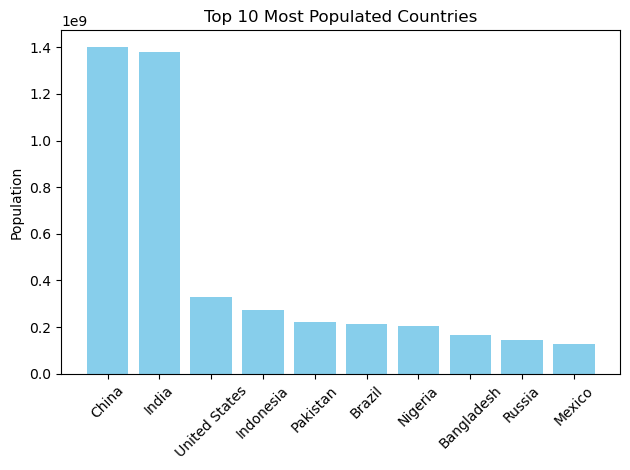

In [15]:
import matplotlib.pyplot as plt


top_pop = df.nlargest(10, 'population')
plt.bar(top_pop['name'], top_pop['population'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Population")
plt.title("Top 10 Most Populated Countries")
plt.tight_layout()
plt.show()

# Population by region

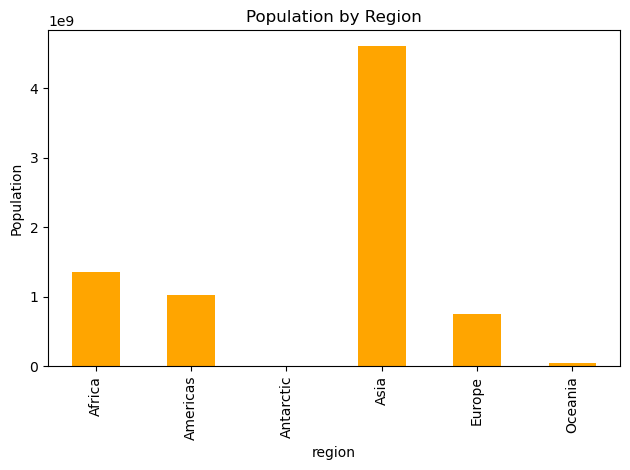

In [16]:

pop_region = df.groupby('region')['population'].sum()
pop_region.plot(kind='bar', title='Population by Region', color='orange')
plt.ylabel("Population")
plt.tight_layout()
plt.show()
